In [14]:
# Dependencies
import os
import pandas as pd
import gmaps
import requests
import json
import matplotlib.pyplot as plt
import numpy as np

# Google developer API key
from config import gkey

In [15]:
#Outline filepath for CSVs 
inspections = "Resources/inspections.csv"
violations = "Resources/violations.csv"
violation_count = "Resources/violation_count.csv"
zip_codes = "Resources/us_zip_codes.csv"
real_estate = "Resources/rent_by_zip.csv"
facilities = "Resources/facilities_by_zip.csv"

#Read CSVs as pandas dataframes
inspections = pd.read_csv(inspections)
violations = pd.read_csv(violations)
zip_codes = pd.read_csv(zip_codes)
real_estate = pd.read_csv(real_estate)
facilities = pd.read_csv(facilities)
violation_count = pd.read_csv(violation_count)

In [36]:
# Drop unnecessary columns 
clean_df = inspections.drop(["serial_number","service_code","service_description","grade","program_status","pe_description", "employee_id","facility_state","record_id", "owner_name", "owner_id", "program_element_pe","program_name", "activity_date"],axis =1)

# Rename column labels
renamed_df = clean_df.rename(columns={  "activity_date":"Activity Date",
                                        "facility_name": "Facility Name",
                                        "score": "Score",
                                        "grade": "Grade",
                                        "facility_city": "City",
                                        "facility_id": "Facility ID",
                                        "facility_address": "Address",
                                        "facility_zip": "Zip Code",
                                        "program_status": "Status"})
#Merging lat/long for zip code 
renamed_df = renamed_df.merge(violation_count, on="Zip Code", how="left")

#Merging lat/long for zip code 
renamed_df = renamed_df.merge(zip_codes, on="Zip Code", how="left")

#Merging Facilities for each meaningful zip code to count only zip codes with multiple inspections 
renamed_df = renamed_df.merge(facilities, on="Zip Code", how="left")

renamed_df["Count per Facility"] = (renamed_df["Violation Count"]/renamed_df["Facilities"])

renamed_df.head()

,Facility Name,Score,Address,City,Facility ID,Zip Code,Violation Count,Lat,Long,Facilities,Count per Facility
0,HABITAT COFFEE SHOP,95,3708 N EAGLE ROCK BLVD,LOS ANGELES,FA0170465,90065,3118.0,34.112272,-118.225496,136.0,22.926471
1,REILLY'S,92,100 WORLD WAY # 120,LOS ANGELES,FA0244690,90045,8533.0,33.942108,-118.417488,440.0,19.393182
2,STREET CHURROS,93,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,FA0224109,90028,10410.0,34.099912,-118.326912,498.0,20.903614
3,RIO GENTLEMANS CLUB,93,13124 S FIGUEROA ST,LOS ANGELES,FA0046462,90064,5282.0,34.037251,-118.423573,257.0,20.552529
4,LE PAIN QUOTIDIEN,93,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,FA0034788,90049,2364.0,34.092540,-118.491064,117.0,20.205128


In [37]:
# Create dataframe with only score and zipcode 
zip_data = renamed_df[["Score","Zip Code","Facilities", "Lat", "Long", "Count per Facility"]].groupby("Zip Code").mean()

# Drop any rows with a NaN value 
zip_data = zip_data.dropna(how="any")

# Reset the index
zip_data.reset_index(inplace=True)

# Merged median rent data
zip_data = zip_data.merge(real_estate, on="Zip Code", how = "left")

zip_data = zip_data.dropna(how="any")

# List data by descending median rent 
zip_data.sort_values(by="Median Rent 2016",ascending=False).head()

,Zip Code,Score,Facilities,Lat,Long,Count per Facility,Median Rent 2016
62,90094,94.119048,11.0,33.975414,-118.416990,15.363636,2504.00
60,90077,93.592593,21.0,34.108023,-118.456964,24.000000,2400.60
46,90049,95.020472,117.0,34.092540,-118.491064,20.205128,2314.61
56,90067,92.708333,132.0,34.057597,-118.413998,19.810606,2081.33
22,90024,92.427663,220.0,34.065723,-118.434969,30.122727,1986.69


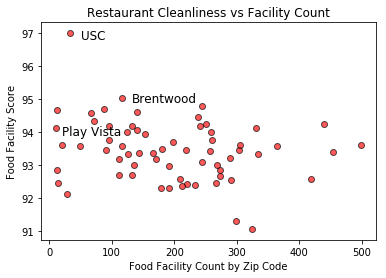

<Figure size 432x288 with 0 Axes>

In [38]:
# Does the number of facilities by zip code have an impact on the Average Food Score for the zip code?
plt.scatter(zip_data["Facilities"],zip_data["Score"], c='red', alpha=.65, edgecolors = "black")
plt.title("Restaurant Cleanliness vs Facility Count")
plt.xlabel("Food Facility Count by Zip Code")
plt.ylabel("Food Facility Score")


usc_score = 96.8
usc_count = 50
plt.text(x = usc_count, y = usc_score, s = "USC", fontsize = 12)

playa_score = 93.9
playa_count = 20
plt.text(x = playa_count, y = playa_score, s = "Play Vista", fontsize = 12)

brentwood_score = 94.9
brentwood_count = 132
plt.text(x = brentwood_count, y = brentwood_score, s = "Brentwood", fontsize = 12)


plt.show()
plt.savefig("restaurant_cleanliness_vs_facility_count.png")

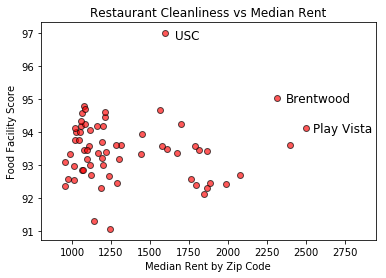

<Figure size 432x288 with 0 Axes>

In [39]:
# Is median rent correlate with higher rated food facilities?
plt.scatter(zip_data["Median Rent 2016"],zip_data["Score"],c='red', alpha=.65, edgecolors = "black")
plt.title("Restaurant Cleanliness vs Median Rent")
plt.xlabel("Median Rent by Zip Code")
plt.ylabel("Food Facility Score")

usc_score = 96.8
med_rent = 1660
plt.text(x = med_rent, y = usc_score, s = "USC", fontsize = 12)

playa_score = 94
med_rent = 2550
plt.text(x = med_rent, y = playa_score, s = "Play Vista", fontsize = 12)

brentwood_score = 94.9
med_rent = 2370
plt.text(x = med_rent, y = brentwood_score, s = "Brentwood", fontsize = 12)
plt.xlim(800,2950)

plt.show()
plt.savefig("restaurant_cleanliness_vs_median_rent.png")


In [40]:
top_5_score = zip_data.nlargest(5, "Score")
top_5_score

,Zip Code,Score,Facilities,Lat,Long,Count per Facility,Median Rent 2016
61,90089,97.000000,33.0,34.020221,-118.286035,19.545455,1598.67
46,90049,95.020472,117.0,34.092540,-118.491064,20.205128,2314.61
6,90007,94.790235,245.0,34.028129,-118.284829,17.395918,1078.91
50,90059,94.679868,87.0,33.926262,-118.249883,13.666667,1083.22
47,90056,94.660714,13.0,33.988047,-118.370361,16.307692,1567.29


In [41]:
low_5_score = zip_data.nsmallest(5, "Score")
low_5_score

,Zip Code,Score,Facilities,Lat,Long,Count per Facility,Median Rent 2016
18,90020,91.051108,324.0,34.066379,-118.309870,32.469136,1244.59
4,90005,91.307221,298.0,34.059163,-118.306892,30.862416,1139.79
58,90069,92.112782,28.0,34.093828,-118.381697,24.714286,1847.14
8,90010,92.301523,192.0,34.062148,-118.315889,28.000000,1183.93
32,90035,92.310630,179.0,34.051809,-118.383674,30.815642,1864.43


In [43]:
top_5_violation = zip_data.nlargest(5, "Count per Facility")
top_5_violation

,Zip Code,Score,Facilities,Lat,Long,Count per Facility,Median Rent 2016
18,90020,91.051108,324.0,34.066379,-118.309870,32.469136,1244.59
4,90005,91.307221,298.0,34.059163,-118.306892,30.862416,1139.79
32,90035,92.310630,179.0,34.051809,-118.383674,30.815642,1864.43
22,90024,92.427663,220.0,34.065723,-118.434969,30.122727,1986.69
8,90010,92.301523,192.0,34.062148,-118.315889,28.000000,1183.93


In [42]:
low_5_violation = zip_data.nsmallest(5, "Count per Facility")
low_5_violation

,Zip Code,Score,Facilities,Lat,Long,Count per Facility,Median Rent 2016
1,90002,94.570175,67.0,33.949099,-118.246737,12.820896,1063.87
50,90059,94.679868,87.0,33.926262,-118.249883,13.666667,1083.22
19,90021,94.176955,132.0,34.029036,-118.237870,14.977273,1059.25
51,90061,93.465190,91.0,33.921280,-118.274186,15.153846,1095.65
62,90094,94.119048,11.0,33.975414,-118.416990,15.363636,2504.00


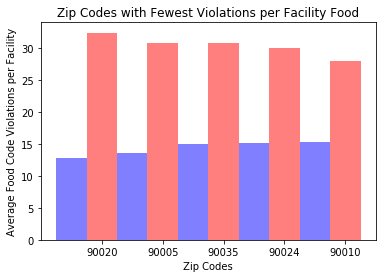

In [72]:
# Highest inspection score
low_zips = ["90002", "90059", "90021","90061", "90094"]
top_zips = ["90020", "90005", "90035","90024", "90010"]
ind = np.arange(len(low_zips))
ind1 = np.arange(len(top_zips))
width = 0.5
low_count = low_5_violation["Count per Facility"][0:5]
top_count = top_5_violation["Count per Facility"][0:5]
plt.bar(ind,low_count, width =.5, color="blue", alpha=0.5, align="center", label="Average Food Code Violations per Facility")
plt.bar(ind1 + width,top_count, width =.5, color="red", alpha=0.5, align="center", label="Average Food Code Violations per Facility")


plt.xticks(ind, low_zips , rotation="horizontal")
plt.xticks(ind1 + width, top_zips , rotation="horizontal")

plt.ylabel("Average Food Code Violations per Facility")
plt.xlabel("Zip Codes")

# plt.legend(loc="upper right")
plt.title("Zip Codes with Fewest Violations per Food Facility")

plt.show()


Text(0.5, 1.0, 'Neighborhoods with Cleanest Food Facility')

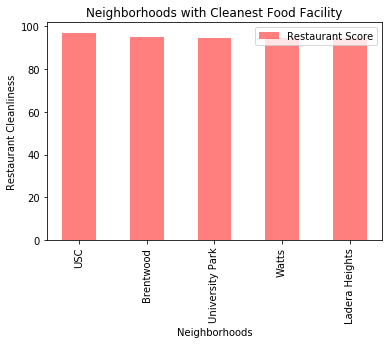

In [24]:
# Highest inspection score
neighborhoods = ["USC", "Brentwood", "University Park","Watts", "Ladera Heights"]
ind = np.arange(len(neighborhoods))
score = top_5_score["Score"][0:5]
plt.bar(ind,score, width =.5, color="red", alpha=0.5, align="center", label="Restaurant Score")

plt.xticks(ind, neighborhoods , rotation="vertical")

plt.ylabel("Restaurant Cleanliness")
plt.xlabel("Neighborhoods")

plt.legend(loc="upper right")
plt.title("Neighborhoods with Cleanest Food Facility")

In [25]:
# Correlation between Median Rent and Score 
x = zip_data["Median Rent 2016"]
y = zip_data["Score"]

print (pearson_r(x, y))

0.00795683714224468


In [26]:
google_map = renamed_df.dropna(how="any")

# Access maps with unique API key
gmaps.configure(api_key=gkey)

locations = google_map[['Lat', 'Long']]
weights = google_map['Score']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights, max_intensity = .5, opacity=1))
fig

Figure(layout=FigureLayout(height='420px'))

In [27]:
google_map1 = renamed_df.dropna(how="any")

# Access maps with unique API key
gmaps.configure(api_key=gkey)

locations = google_map1[['Lat', 'Long']]
weights = google_map1['Violation Count']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations,weights=weights, max_intensity = .5, opacity=1))
fig

Figure(layout=FigureLayout(height='420px'))

In [28]:
# Correlation between Median Rent and Score 
x = zip_data["Median Rent 2016"]
y = zip_data["Score"]

print (pearson_r(x, y))

0.00795683714224468


In [29]:
def pearson_r(x, y):

    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

# Compute Pearson correlation coefficient for I. versicolor: r
r = pearson_r(x, y)

# Print the result
print(r)

if (r < 0):
    print(f"Since r = {round(r,4)}, is negative; as {x} variable increases, {y} decreases.")
    if(r <= -0.75):
        print(f"Since r = {round(r,4)} is close to -1; There is a strong inverse relationship between these two variables.")
if (r > 0):
    print(f"Since r = {round(r,4)}, is positive; both variables increase together, or decrease together.")
    if (r >= 0.75):
        print(f"Since r = {round(r,4)} is close to 1; There is a strong positive relationship between these two variables.")
    else:
        print("There is a weak or no association between both variables.")

0.00795683714224468
Since r = 0.008, is positive; both variables increase together, or decrease together.
There is a weak or no association between both variables.


In [74]:
# Correlation between Median Rent and Score 
y = zip_data["Median Rent 2016"]
x = zip_data["Count per Facility"]

print (pearson_r(x, y))

0.2745316030984559


In [ ]:
# Median inspection score
median_score = renamed_df.median()
median_score

In [ ]:
# Average Inspection score 
avg_score = renamed_df.loc[:,"Score"].mean()
avg_score 